In [ ]:
%%writefile spmv.cu
#include <iostream>
#include <vector>
#include <random>
#include <chrono>
#include <fstream>
#include <cmath>
#include <algorithm>
#include <cuda_runtime.h>

// Serial
void spmv_serial(
    int n_rows,
    const std::vector<int>& row_ptr,
    const std::vector<int>& col_idx,
    const std::vector<double>& values,
    const std::vector<double>& x,
    std::vector<double>& y
) {
    for (int i = 0; i < n_rows; i++) {
        double sum = 0.0;
        for (int j = row_ptr[i]; j < row_ptr[i + 1]; j++) {
            sum += values[j] * x[col_idx[j]];
        }
        y[i] = sum;
    }
}

// Parallel
__global__
void spmv_csr_kernel(
    int n_rows,
    const int* row_ptr,
    const int* col_idx,
    const double* values,
    const double* x,
    double* y
) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < n_rows) {
        double sum = 0.0;
        for (int j = row_ptr[row]; j < row_ptr[row + 1]; j++) {
            sum += values[j] * x[col_idx[j]];
        }
        y[row] = sum;
    }
}

// Random Generation
void generate_random_csr(
    int n_rows,
    int n_cols,
    double sparsity,
    std::vector<int>& row_ptr,
    std::vector<int>& col_idx,
    std::vector<double>& values
) {
    row_ptr.clear();
    col_idx.clear();
    values.clear();
    std::mt19937 gen(42);
    std::uniform_real_distribution<double> dist_val(1.0, 10.0);
    std::uniform_int_distribution<int> dist_col(0, n_cols - 1);
    row_ptr.push_back(0);
    for (int i = 0; i < n_rows; i++) {
        int nnz_row = std::max(1, int(n_cols * (1.0 - sparsity)));
        std::vector<int> cols;
        while (cols.size() < nnz_row) {
            int c = dist_col(gen);
            if (std::find(cols.begin(), cols.end(), c) == cols.end()) {
                cols.push_back(c);
            }
        }
        std::sort(cols.begin(), cols.end());
        for (int c : cols) {
            col_idx.push_back(c);
            values.push_back(dist_val(gen));
        }
        row_ptr.push_back(col_idx.size());
    }
}

// Correctness
bool validate(
    const std::vector<double>& ref,
    const std::vector<double>& test
) {
    if (ref.size() != test.size()) return false;
    for (size_t i = 0; i < ref.size(); i++) {
        if (std::abs(ref[i] - test[i]) > 1e-6) return false;
    }
    return true;
}

// Experiments
int main() {
    // Benchmark.
    std::vector<int> sizes = {512, 1024, 2048, 4096, 8192, 16384};
    std::vector<double> sparsities = {0.5, 0.7, 0.85, 0.9, 0.95, 0.975, 0.99};
    std::vector<int> cuda_block_sizes = {32, 64, 128, 256, 512, 1024};
    int n_runs = 20;

    std::ofstream fout("spmv_experiments.csv");
    fout << "version,rows,cols,nnz,sparsity,blockSize,time_ms,valid\n";
    for (auto n_rows : sizes) {
        int n_cols = n_rows;
        for (auto sparsity : sparsities) {
            std::vector<int> row_ptr, col_idx;
            std::vector<double> values, x(n_cols), y_serial(n_rows), y_cuda(n_rows);
            std::mt19937 gen(123);
            std::uniform_real_distribution<double> dist(0.0, 1.0);
            for (int i = 0; i < n_cols; i++) x[i] = dist(gen);
            generate_random_csr(n_rows, n_cols, sparsity, row_ptr, col_idx, values);
            int nnz = values.size();
            // Serial
            double elapsed_serial = 0.0;
            for (int k = 0; k < n_runs; k++) {
                auto start = std::chrono::high_resolution_clock::now();
                spmv_serial(n_rows, row_ptr, col_idx, values, x, y_serial);
                auto end   = std::chrono::high_resolution_clock::now();
                elapsed_serial += std::chrono::duration<double, std::milli>(end - start).count();
            }
            elapsed_serial /= n_runs;
            fout << "serial," << n_rows << "," << n_cols << ","
                 << nnz << "," << sparsity << ",NA,"
                 << elapsed_serial << ",1\n";
            // Parallel
            for (auto blockSize : cuda_block_sizes) {
                int *d_row_ptr, *d_col_idx;
                double *d_values, *d_x, *d_y;
                cudaMalloc(&d_row_ptr, (n_rows + 1) * sizeof(int));
                cudaMalloc(&d_col_idx, nnz * sizeof(int));
                cudaMalloc(&d_values, nnz * sizeof(double));
                cudaMalloc(&d_x, n_cols * sizeof(double));
                cudaMalloc(&d_y, n_rows * sizeof(double));
                cudaMemcpy(d_row_ptr, row_ptr.data(), (n_rows + 1) * sizeof(int), cudaMemcpyHostToDevice);
                cudaMemcpy(d_col_idx, col_idx.data(), nnz * sizeof(int), cudaMemcpyHostToDevice);
                cudaMemcpy(d_values, values.data(), nnz * sizeof(double), cudaMemcpyHostToDevice);
                cudaMemcpy(d_x, x.data(), n_cols * sizeof(double), cudaMemcpyHostToDevice);
                int gridSize = (n_rows + blockSize - 1) / blockSize;
                cudaEvent_t start, stop;
                cudaEventCreate(&start);
                cudaEventCreate(&stop);
                cudaEventRecord(start);
                for (int k = 0; k < n_runs; k++) {
                    spmv_csr_kernel<<<gridSize, blockSize>>>(n_rows, d_row_ptr, d_col_idx, d_values, d_x, d_y);
                }
                cudaEventRecord(stop);
                cudaEventSynchronize(stop);
                float elapsed_cuda;
                cudaEventElapsedTime(&elapsed_cuda, start, stop);
                elapsed_cuda /= n_runs;
                cudaMemcpy(y_cuda.data(), d_y, n_rows * sizeof(double), cudaMemcpyDeviceToHost);
                bool valid = validate(y_serial, y_cuda);
                fout << "cuda," << n_rows << "," << n_cols << ","
                     << nnz << "," << sparsity << "," << blockSize << ","
                     << elapsed_cuda << "," << valid << "\n";
                cudaFree(d_row_ptr);
                cudaFree(d_col_idx);
                cudaFree(d_values);
                cudaFree(d_x);
                cudaFree(d_y);
                std::cout << "Done: size=" << n_rows
                          << ", sparsity=" << sparsity
                          << ", block=" << blockSize
                          << ", valid=" << valid << std::endl;
            }
        }
    }
    fout.close();
    return 0;
}

Writing spmv.cu


In [ ]:
!nvcc -O3 -arch=sm_75 spmv.cu -o spmv
!./spmv

Done: size=512, sparsity=0.5, block=32, valid=1
Done: size=512, sparsity=0.5, block=64, valid=1
Done: size=512, sparsity=0.5, block=128, valid=1
Done: size=512, sparsity=0.5, block=256, valid=1
Done: size=512, sparsity=0.5, block=512, valid=1
Done: size=512, sparsity=0.5, block=1024, valid=1
Done: size=512, sparsity=0.7, block=32, valid=1
Done: size=512, sparsity=0.7, block=64, valid=1
Done: size=512, sparsity=0.7, block=128, valid=1
Done: size=512, sparsity=0.7, block=256, valid=1
Done: size=512, sparsity=0.7, block=512, valid=1
Done: size=512, sparsity=0.7, block=1024, valid=1
Done: size=512, sparsity=0.85, block=32, valid=1
Done: size=512, sparsity=0.85, block=64, valid=1
Done: size=512, sparsity=0.85, block=128, valid=1
Done: size=512, sparsity=0.85, block=256, valid=1
Done: size=512, sparsity=0.85, block=512, valid=1
Done: size=512, sparsity=0.85, block=1024, valid=1
Done: size=512, sparsity=0.9, block=32, valid=1
Done: size=512, sparsity=0.9, block=64, valid=1
Done: size=512, spa

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("spmv_experiments.csv")
for col in ['blockSize','time_ms','rows','nnz','sparsity']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_serial = df[df['version']=='serial']
df_cuda = df[df['version']=='cuda']
sparsities = sorted(df['sparsity'].unique())
block_sizes = sorted(df_cuda['blockSize'].dropna().unique())

performance_tables = {}
for s in sparsities:
    rows_list = sorted(df_serial['rows'].unique())
    table = []
    for r in rows_list:
        serial_time = df_serial[(df_serial['sparsity']==s) & (df_serial['rows']==r)]['time_ms'].values[0]
        best_cuda_time = np.inf
        best_block = None
        for b in block_sizes:
            cuda_time = df_cuda[(df_cuda['sparsity']==s) & (df_cuda['rows']==r) & (df_cuda['blockSize']==b)]['time_ms']
            if not cuda_time.empty and cuda_time.values[0] < best_cuda_time:
                best_cuda_time = cuda_time.values[0]
                best_block = b

        speedup = serial_time / best_cuda_time if best_cuda_time != np.inf else None
        table.append({
            'Matrix Size': r,
            'Serial Time (ms)': serial_time,
            'Best CUDA Time (ms)': best_cuda_time,
            'Best Block Size': best_block,
            'Speedup': speedup
        })

    performance_tables[s] = pd.DataFrame(table)
print("Performance Table (Sparsity = {})".format(sparsities[0]))
performance_tables[sparsities[0]]

Performance Table (Sparsity = 0.5)


,Matrix Size,Serial Time (ms),Best CUDA Time (ms),Best Block Size,Speedup
0,512,0.167527,0.063387,32.0,2.642915
1,1024,0.680614,0.162907,64.0,4.177930
2,2048,2.873610,0.425592,32.0,6.752030
3,4096,12.921800,1.783050,32.0,7.247021
4,8192,52.183300,3.472070,256.0,15.029449
5,16384,206.322000,15.154900,64.0,13.614211


In [ ]:
print("Performance Table (Sparsity = {})".format(sparsities[1]))
performance_tables[sparsities[1]]

Performance Table (Sparsity = 0.7)


,Matrix Size,Serial Time (ms),Best CUDA Time (ms),Best Block Size,Speedup
0,512,0.099579,0.032011,32.0,3.110752
1,1024,0.414596,0.059291,32.0,6.992539
2,2048,1.750720,0.131976,32.0,13.265442
3,4096,7.782860,0.768363,32.0,10.129145
4,8192,32.331400,2.171040,256.0,14.892125
5,16384,125.361000,10.738300,64.0,11.674194


In [ ]:
print("Performance Table (Sparsity = {})".format(sparsities[2]))
performance_tables[sparsities[2]]

Performance Table (Sparsity = 0.85)


,Matrix Size,Serial Time (ms),Best CUDA Time (ms),Best Block Size,Speedup
0,512,0.044298,0.018434,32.0,2.403101
1,1024,0.190112,0.032454,32.0,5.857819
2,2048,0.828749,0.063773,64.0,12.995337
3,4096,3.739740,0.258357,32.0,14.475087
4,8192,15.283800,1.491760,32.0,10.245482
5,16384,63.356400,5.237830,64.0,12.095925


In [ ]:
print("Performance Table (Sparsity = {})".format(sparsities[3]))
performance_tables[sparsities[3]]

Performance Table (Sparsity = 0.9)


,Matrix Size,Serial Time (ms),Best CUDA Time (ms),Best Block Size,Speedup
0,512,0.023181,0.014418,32.0,1.607820
1,1024,0.189413,0.023349,32.0,8.112323
2,2048,0.532481,0.039592,64.0,13.449207
3,4096,2.307090,0.153702,32.0,15.010150
4,8192,10.470600,0.919640,32.0,11.385542
5,16384,41.347700,3.372590,256.0,12.259925


In [ ]:
print("Performance Table (Sparsity = {})".format(sparsities[4]))
performance_tables[sparsities[4]]

Performance Table (Sparsity = 0.95)


,Matrix Size,Serial Time (ms),Best CUDA Time (ms),Best Block Size,Speedup
0,512,0.011132,0.009045,32.0,1.230751
1,1024,0.048583,0.014651,32.0,3.315988
2,2048,0.264408,0.017434,64.0,15.166575
3,4096,1.096590,0.083070,32.0,13.200731
4,8192,5.066000,0.324482,32.0,15.612576
5,16384,20.495600,1.702860,256.0,12.035987


In [ ]:
print("Performance Table (Sparsity = {})".format(sparsities[5]))
performance_tables[sparsities[5]]

Performance Table (Sparsity = 0.975)


,Matrix Size,Serial Time (ms),Best CUDA Time (ms),Best Block Size,Speedup
0,512,0.005152,0.006658,32.0,0.773792
1,1024,0.023679,0.008912,32.0,2.656923
2,2048,0.102891,0.010864,64.0,9.470821
3,4096,0.526402,0.042909,32.0,12.267926
4,8192,2.269950,0.156570,32.0,14.497988
5,16384,10.350000,0.769605,64.0,13.448457


In [ ]:
print("Performance Table (Sparsity = {})".format(sparsities[6]))
performance_tables[sparsities[6]]

Performance Table (Sparsity = 0.99)


,Matrix Size,Serial Time (ms),Best CUDA Time (ms),Best Block Size,Speedup
0,512,0.001906,0.005736,32.0,0.332357
1,1024,0.007402,0.006611,64.0,1.119562
2,2048,0.035354,0.005112,64.0,6.915962
3,4096,0.176776,0.019661,32.0,8.991292
4,8192,0.803930,0.066075,32.0,12.166895
5,16384,3.949970,0.300090,64.0,13.162618


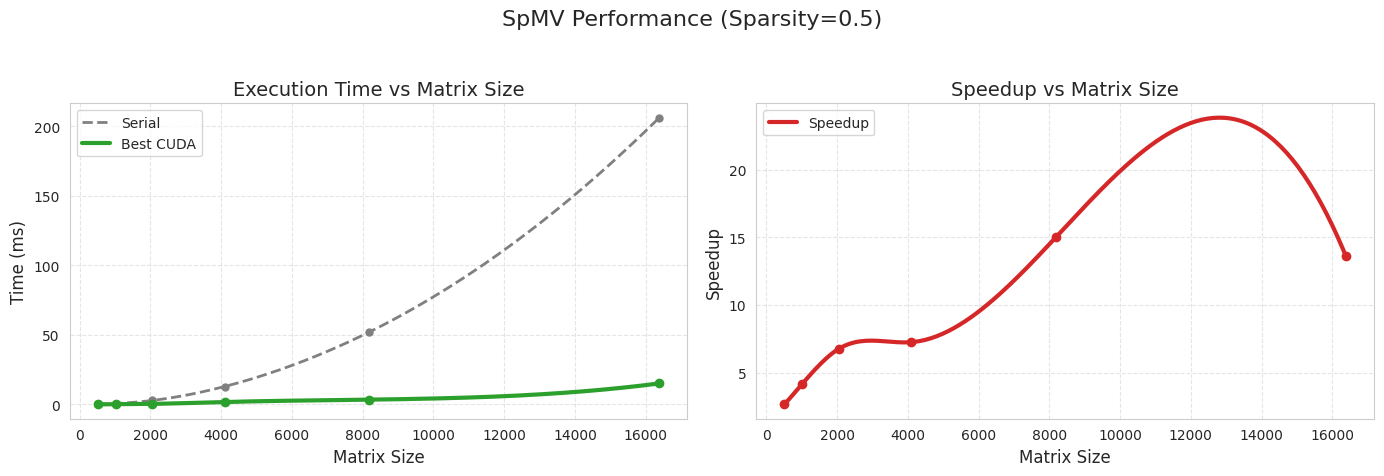

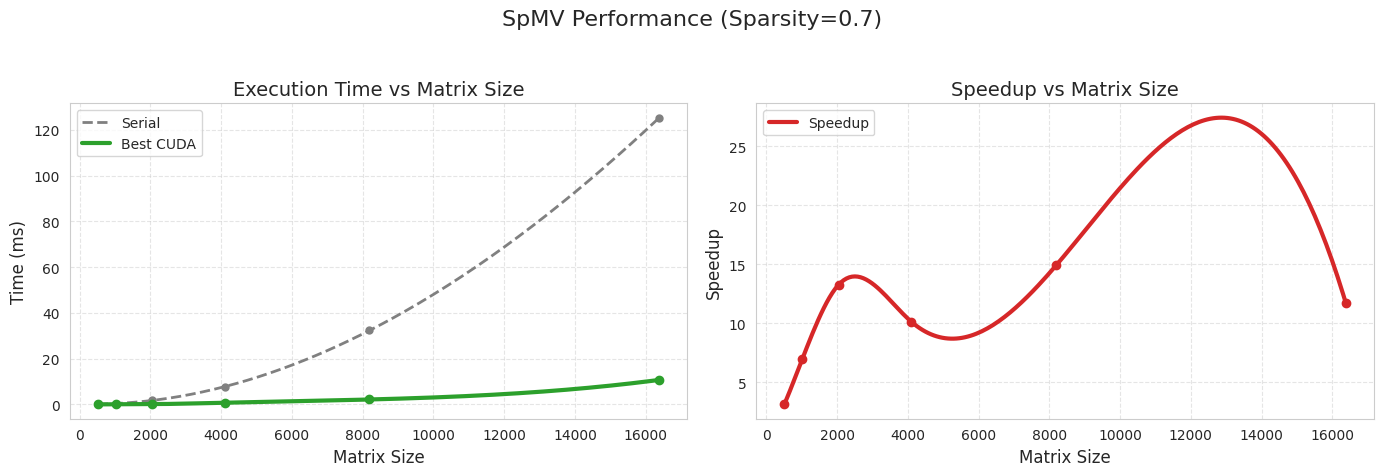

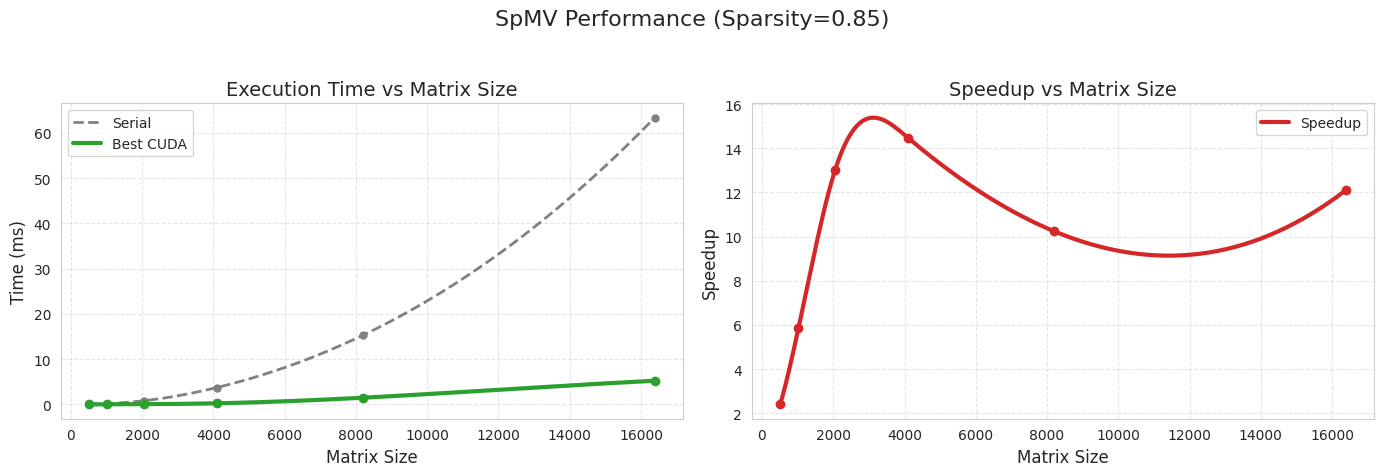

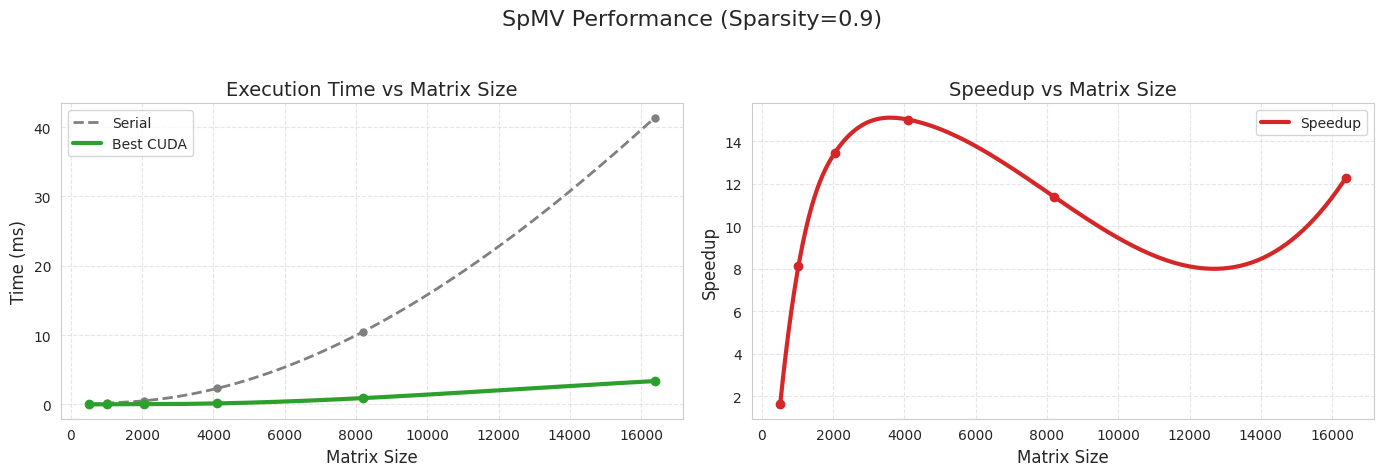

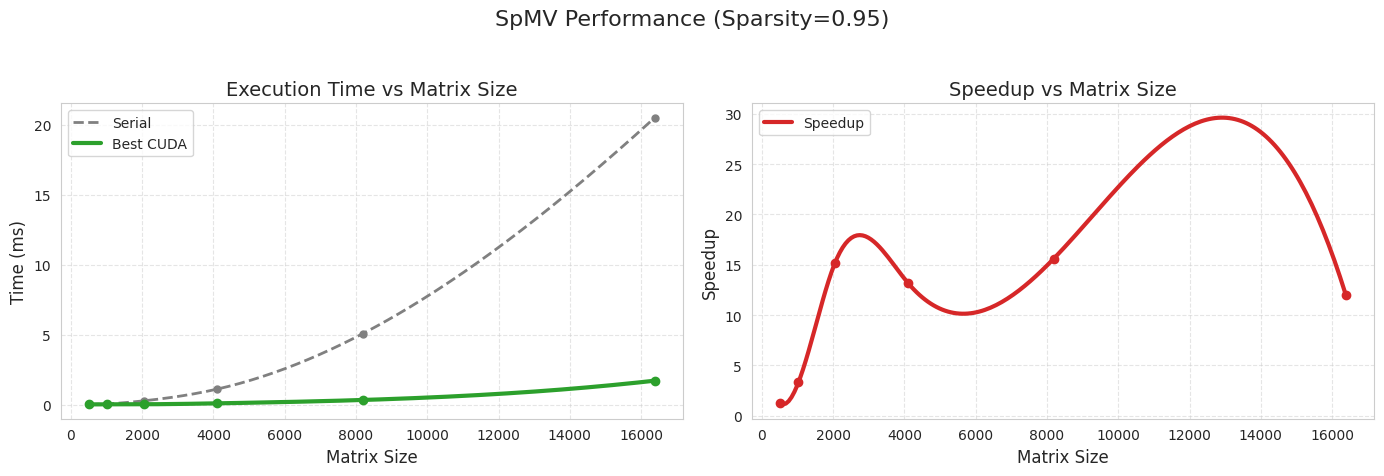

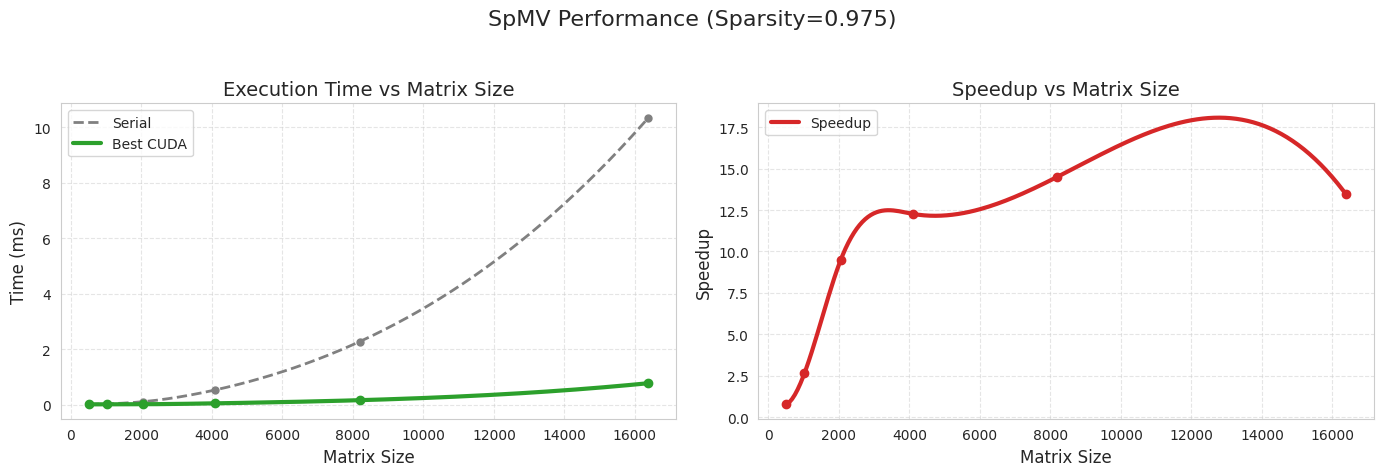

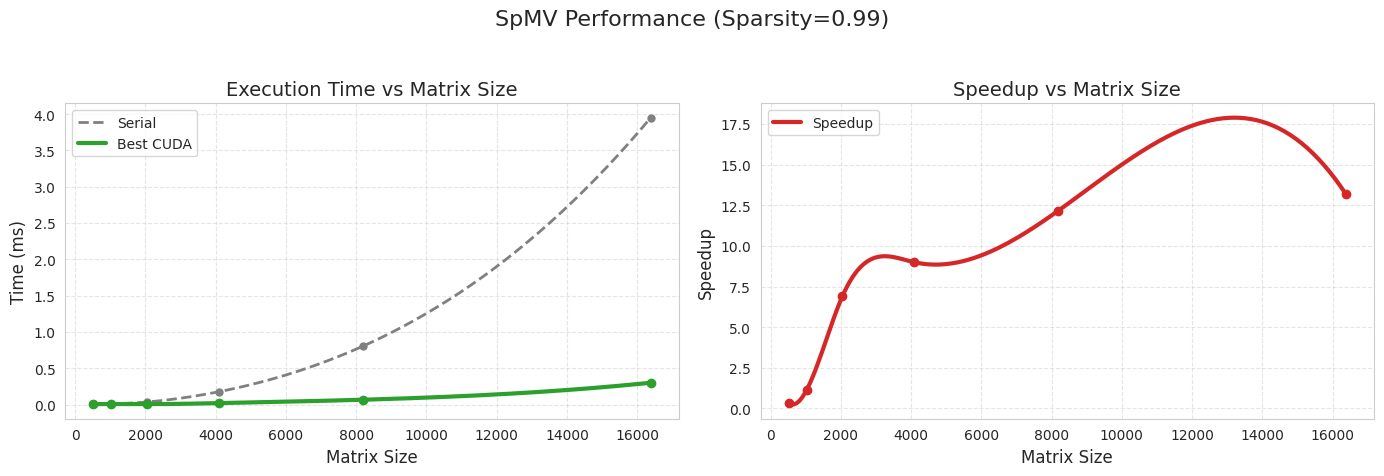

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

sns.set_style("whitegrid")
palette = sns.color_palette("tab10")
for s in sparsities:
    df_table = performance_tables[s]
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle(f"SpMV Performance (Sparsity={s})", fontsize=16)
    x = df_table['Matrix Size'].values

    # Execution Time
    ax = axs[0]
    # Serial
    y_serial = df_table['Serial Time (ms)'].values
    f_serial = interp1d(x, y_serial, kind='cubic')
    x_smooth = np.linspace(x.min(), x.max(), 200)
    ax.plot(x_smooth, f_serial(x_smooth), '--', color='gray', label='Serial', linewidth=2)
    ax.plot(x, y_serial, 'o', color='gray', markersize=5)
    # Best CUDA
    y_cuda = df_table['Best CUDA Time (ms)'].values
    f_cuda = interp1d(x, y_cuda, kind='cubic')
    ax.plot(x_smooth, f_cuda(x_smooth), '-', color=palette[2], label='Best CUDA', linewidth=3)
    ax.plot(x, y_cuda, 'o', color=palette[2], markersize=6)
    ax.set_xlabel("Matrix Size")
    ax.set_ylabel("Time (ms)")
    ax.set_title("Execution Time vs Matrix Size")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

    # Speedup
    ax = axs[1]
    y_speedup = df_table['Speedup'].values
    f_speedup = interp1d(x, y_speedup, kind='cubic')
    ax.plot(x_smooth, f_speedup(x_smooth), '-', color=palette[3], label='Speedup', linewidth=3)
    ax.plot(x, y_speedup, 'o', color=palette[3], markersize=6)
    ax.set_xlabel("Matrix Size")
    ax.set_ylabel("Speedup")
    ax.set_title("Speedup vs Matrix Size")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()